In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,BaggingClassifier
from sklearn.metrics import roc_auc_score,roc_curve,accuracy_score,confusion_matrix
import statsmodels.api as sm
from typing import Dict


df = pd.read_csv('https://raw.githubusercontent.com/nickkats1/sklearn_only/refs/heads/main/creditrisk/data/raw/data.csv')
print(f"Unique Columns: {df.nunique()}")
print(f"dtypes: {df.dtypes}")
print(f"null columns: {df.isnull().sum()}")
print(f"Duplicated Columns: {df.duplicated().sum()}")
print(f"column names: {df.columns}")

Unique Columns: Default              2
checkingstatus1      4
duration            33
history              5
purpose             10
amount             921
savings              5
employ               5
installment          4
status               4
others               3
residence            4
property             4
age                 53
otherplans           3
housing              3
cards                4
job                  4
liable               2
tele                 2
foreign              2
dtype: int64
dtypes: Default            int64
checkingstatus1    int64
duration           int64
history            int64
purpose            int64
amount             int64
savings            int64
employ             int64
installment        int64
status             int64
others             int64
residence          int64
property           int64
age                int64
otherplans         int64
housing            int64
cards              int64
job                int64
liable             int64
tele 

In [2]:
#rename a column

df.rename(columns={"property":"prop"},inplace=True)


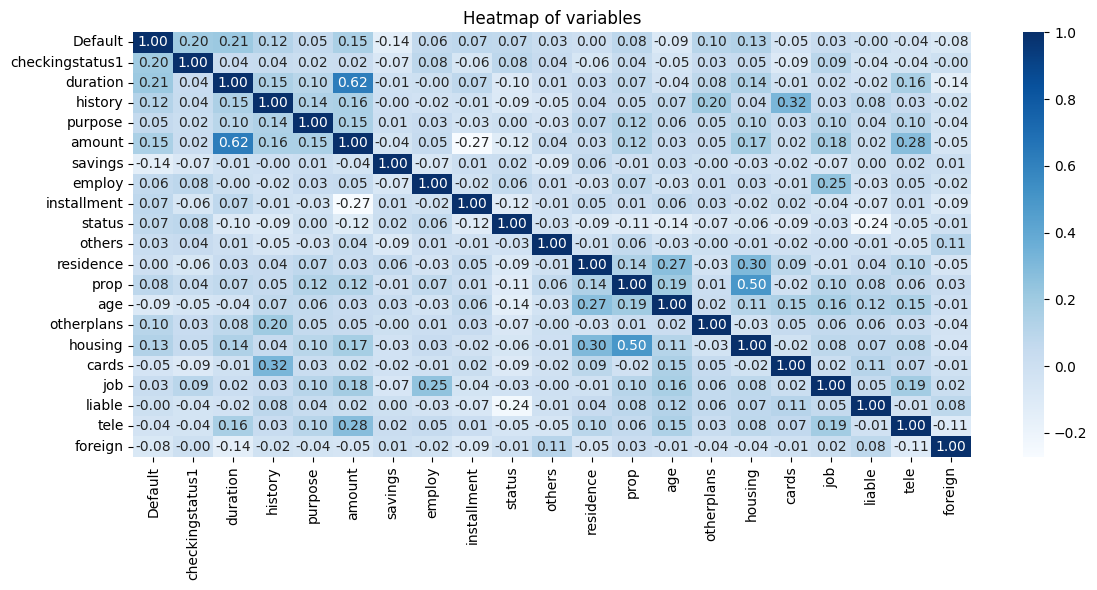

In [3]:
# object cols and num cols for a heat map

obj_cols=  df.select_dtypes(include="object")
num_cols = df.select_dtypes(include="number")

# label encoder for a simplified heatmap

le = LabelEncoder()

for col in obj_cols.columns:
    le = LabelEncoder()
    obj_cols[col] = le.fit_transform(obj_cols[col])


# only numerical features now
df_combined = pd.concat([obj_cols,num_cols],axis=1)
# correlation heat map

plt.figure(figsize=(12,6))
sns.heatmap(df_combined.corr(),annot=True,fmt=".2f",cmap="Blues")
plt.title("Heatmap of variables")
plt.tight_layout()
plt.savefig("images/heatmap.png")
plt.show()


/tmp/ipykernel_44687/2168715919.py:8: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(x='age',y='duration',ax=axs[1,0],data=df,palette='Blues')


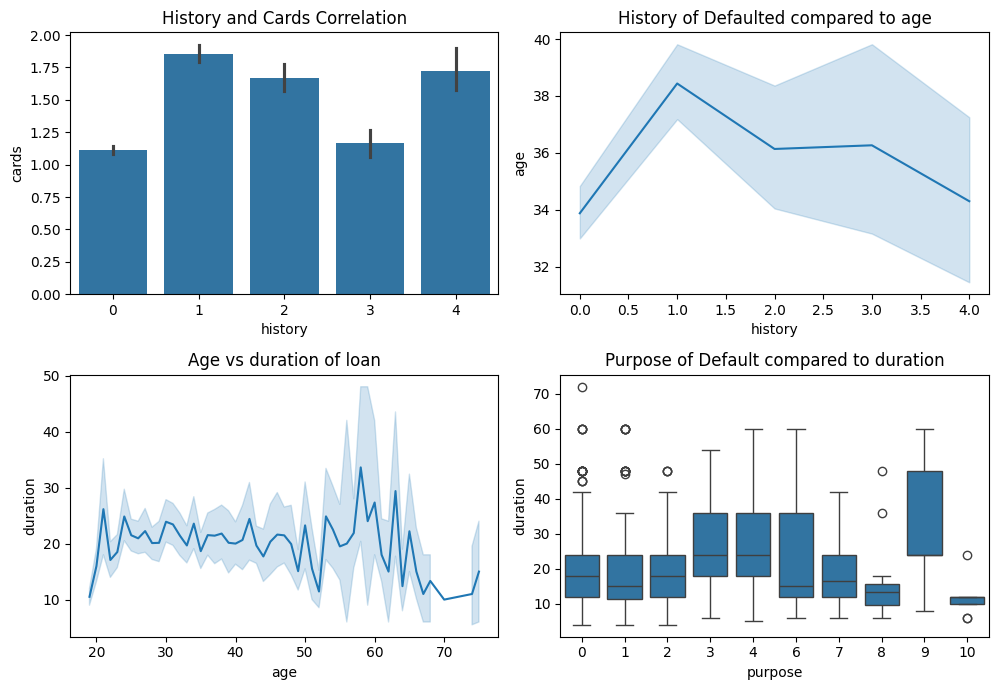

In [4]:
# descriptive stats
fig, axs = plt.subplots(2,2,figsize=(10,7))
sns.barplot(x='history',y='cards',ax=axs[0,0],data=df)
axs[0,0].set_title('History and Cards Correlation')

sns.lineplot(x='history',y='age',ax=axs[0,1],data=df)
axs[0,1].set_title('History of Defaulted compared to age')
sns.lineplot(x='age',y='duration',ax=axs[1,0],data=df,palette='Blues')
axs[1,0].set_title('Age vs duration of loan')
sns.boxplot(x='purpose',y='duration',ax=axs[1,1],data=df)
axs[1,1].set_title('Purpose of Default compared to duration')
plt.tight_layout()
plt.show()

/tmp/ipykernel_44687/249444651.py:6: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(x='amount',ax=axs[0,1],data=df,palette='viridis')


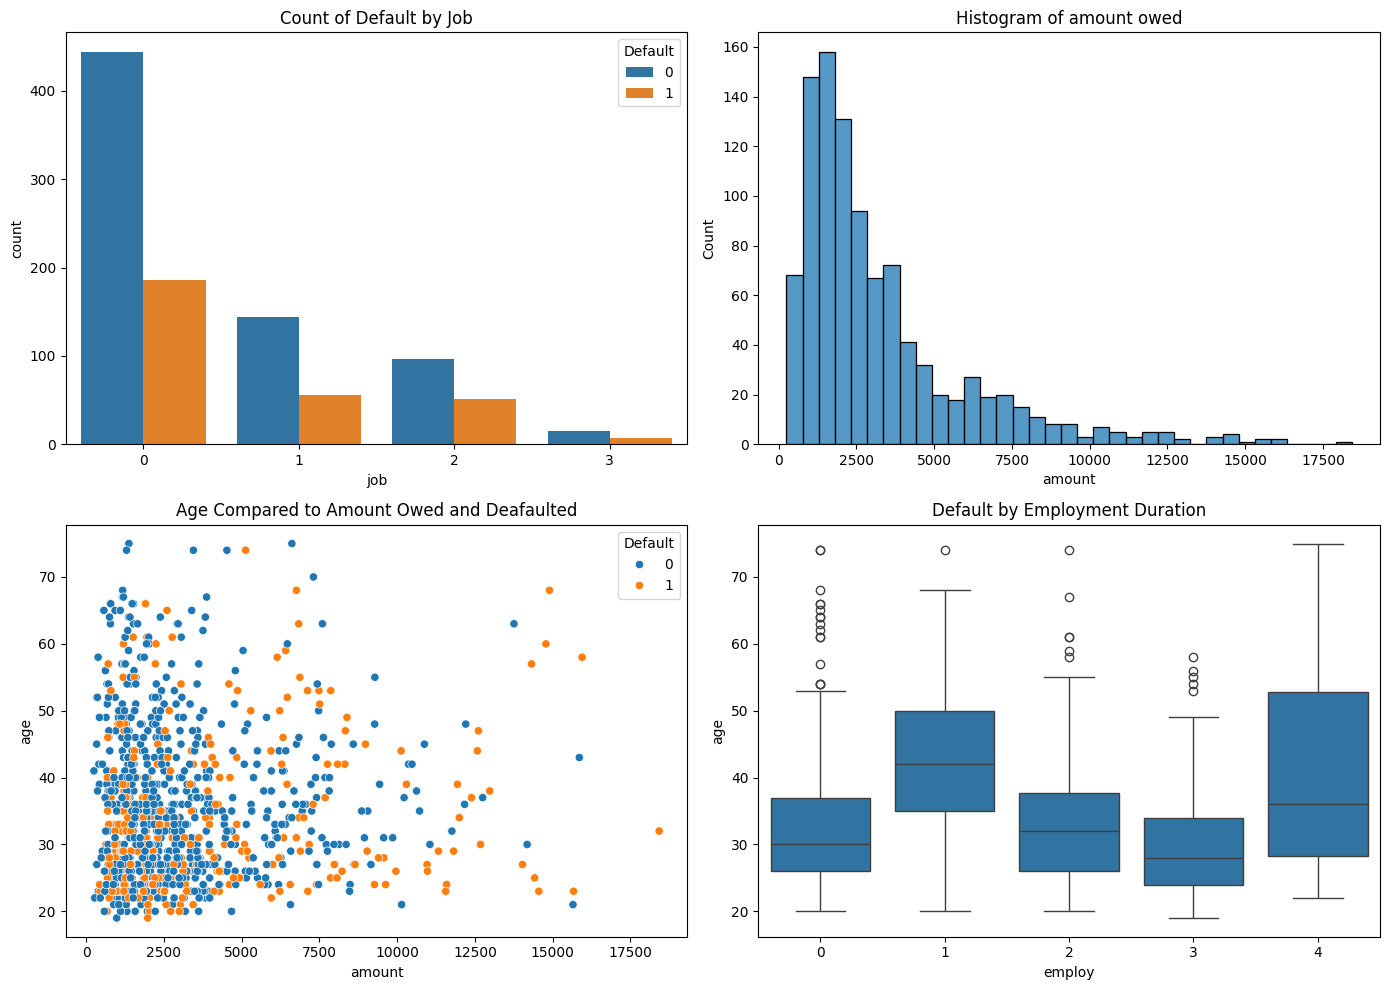

In [5]:
#second set of descriptive stats

fig, axs = plt.subplots(2,2,figsize=(14, 10))
sns.countplot(x='job',hue='Default',ax=axs[0,0],data=df)
axs[0,0].set_title('Count of Default by Job')
sns.histplot(x='amount',ax=axs[0,1],data=df,palette='viridis')
axs[0, 1].set_title('Histogram of amount owed')
sns.scatterplot(x='amount',y='age',ax=axs[1,0],data=df,hue='Default')
axs[1, 0].set_title('Age Compared to Amount Owed and Deafaulted')
sns.boxplot(x='employ',y='age', ax=axs[1,1], data=df)
axs[1,1].set_title('Default by Employment Duration')
plt.tight_layout()
plt.show()

In [6]:
# OLS (the target is binary but this does not matter when trying to find the statistical significance)

X = df_combined.drop("Default",axis=1)
y = df_combined['Default']

model_ols = sm.OLS(exog=sm.add_constant(X),endog=y).fit()
print(f"Anova table: {model_ols.summary()}")


Anova table:                             OLS Regression Results                            
Dep. Variable:                Default   R-squared:                       0.154
Model:                            OLS   Adj. R-squared:                  0.137
Method:                 Least Squares   F-statistic:                     8.901
Date:                Fri, 10 Oct 2025   Prob (F-statistic):           7.93e-25
Time:                        16:40:36   Log-Likelihood:                -555.08
No. Observations:                1000   AIC:                             1152.
Df Residuals:                     979   BIC:                             1255.
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.0364   

In [7]:
# most are statistically significant, but checking history has the highest stat sig


X = df.drop(["Default","housing"],axis=1)
y = df['Default']

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.20,random_state=1)

# scaler for numerical features and one hot encoder for categorical features for pipeline

#standard scaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)













In [8]:
# model selection


models = {
    "LogisticRegression":LogisticRegression(),
    "RandomForestClassifier":RandomForestClassifier(),
    "GradientBoostingClassifier":GradientBoostingClassifier(),
    "BaggingClassifier":BaggingClassifier(),
    "svc":SVC(probability=True),
    "knn":KNeighborsClassifier()

}


# user-defined function to evaluate models


def evaluate(y_test,pred,pred_prob,model_name,cv_scores) -> Dict:
    """ Returns 'result' dictionary with metrics and model name """

    result = {
        "Model":model_name,
        "Accuracy":acc,
        "Rocscore":roc,
        "Cross-Validation Score":cv_scores.mean()
        }
    return result


In [9]:
# dictionary to store results
results = []

# loop to train and test all models



for model_name,model in models.items():
    model.fit(X_train_scaled,y_train)
    pred = model.predict(X_test_scaled)
    pred_prob = model.predict_proba(X_test_scaled)[:,1]
    acc = accuracy_score(y_test, pred)
    roc = roc_auc_score(y_test, pred_prob)
    cv_scores = cross_val_score(model, X_train_scaled,y_train,cv=5,scoring="roc_auc").mean()
    print(f"Accuracy Score: {model_name}---- {acc*100:.2f}")
    print(f"Roc Auc Score: {model_name} ----- {roc*100:.2f}")
    print(f"Results from Five-Fold Average Cross Validation: {cv_scores}")
    evaluation_result = evaluate(y_test, pred, pred_prob,model_name, cv_scores)
    results.append(evaluation_result)





Accuracy Score: LogisticRegression---- 72.50
Roc Auc Score: LogisticRegression ----- 70.41
Results from Five-Fold Average Cross Validation: 0.7272286955322669
Accuracy Score: RandomForestClassifier---- 77.00
Roc Auc Score: RandomForestClassifier ----- 77.25
Results from Five-Fold Average Cross Validation: 0.788854152302813
Accuracy Score: GradientBoostingClassifier---- 76.00
Roc Auc Score: GradientBoostingClassifier ----- 78.45
Results from Five-Fold Average Cross Validation: 0.774648516501195
Accuracy Score: BaggingClassifier---- 75.50
Roc Auc Score: BaggingClassifier ----- 72.41
Results from Five-Fold Average Cross Validation: 0.7538952616519581
Accuracy Score: svc---- 73.00
Roc Auc Score: svc ----- 66.57
Results from Five-Fold Average Cross Validation: 0.7458956724581725
Accuracy Score: knn---- 69.50
Roc Auc Score: knn ----- 59.02
Results from Five-Fold Average Cross Validation: 0.7180022177790034


In [10]:
# dictionary to store and plot results and metrics

df_results = pd.DataFrame(results)
print(df_results.head())


                        Model  Accuracy  Rocscore  Cross-Validation Score
0          LogisticRegression     0.725  0.704051                0.727229
1      RandomForestClassifier     0.770  0.772509                0.788854
2  GradientBoostingClassifier     0.760  0.784469                0.774649
3           BaggingClassifier     0.755  0.724065                0.753895
4                         svc     0.730  0.665705                0.745896


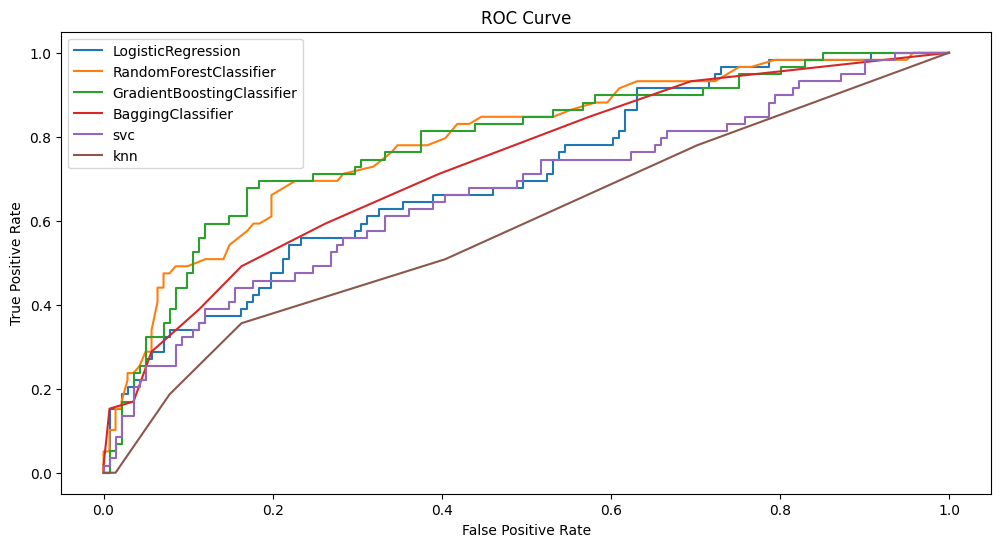

In [12]:
# plots of roc curves


def plot_roc_curve(models,X_test_scaled,y_test):
    plt.figure(figsize=(12,6))
    
    for name, model in models.items():
        model.fit(X_train_scaled,y_train)
        pred_prob = model.predict_proba(X_test_scaled)[:,1]
        fpr, tpr, _ = roc_curve(y_test,pred_prob)
        plt.plot(fpr,tpr,label=name)
    
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()


plot_roc_curve(models, X_test_scaled, y_test)


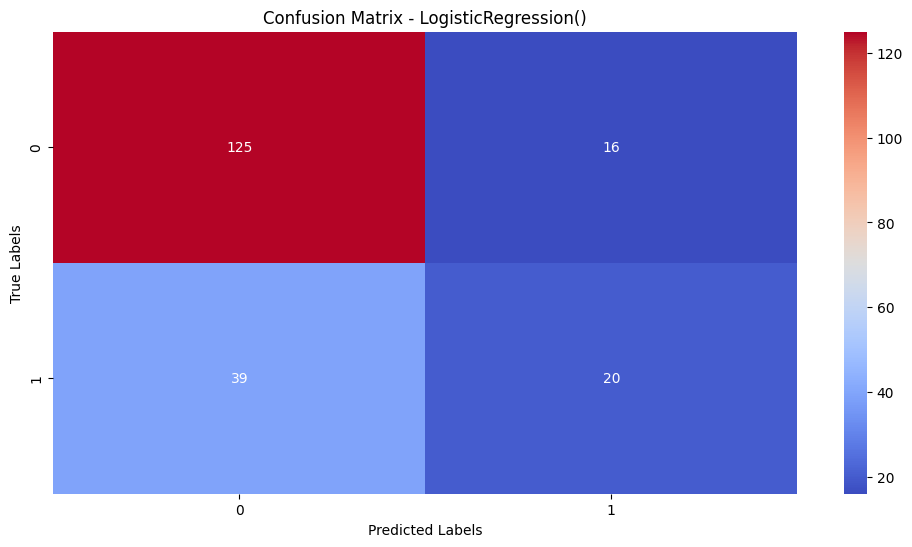

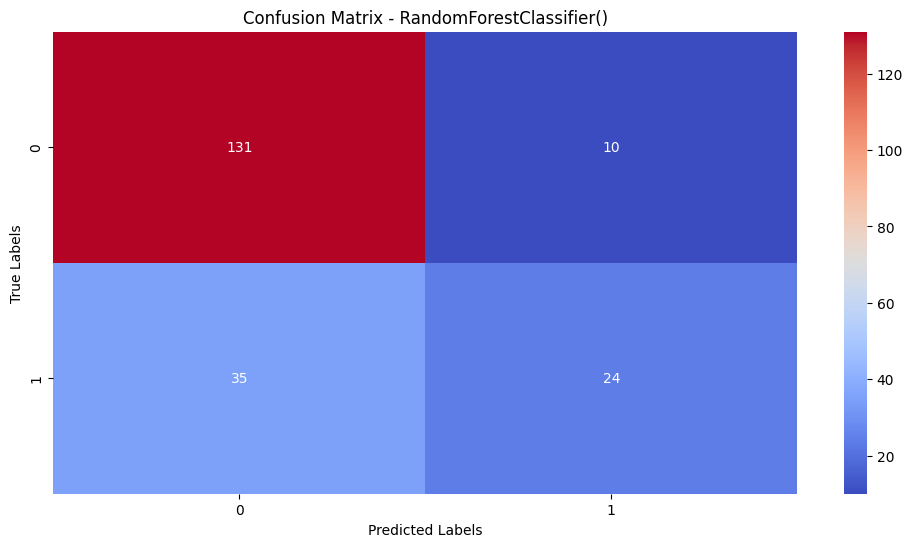

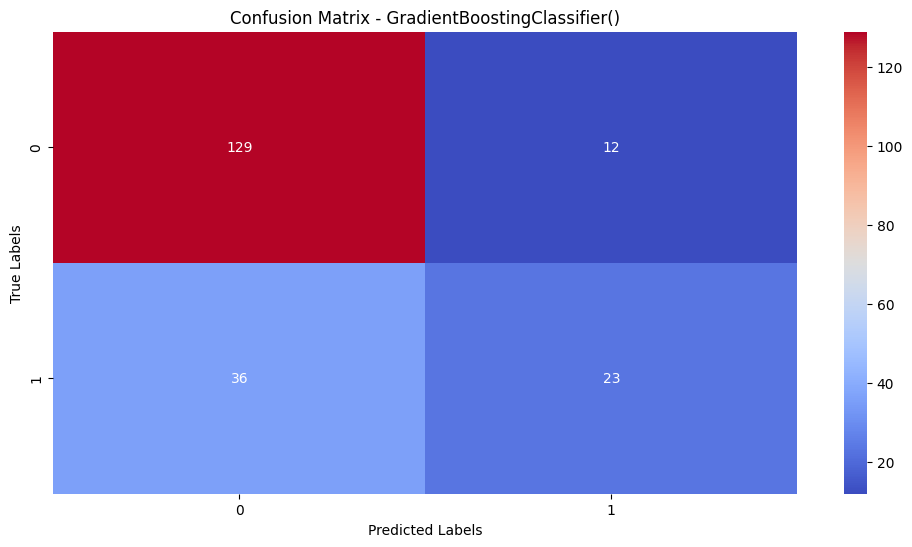

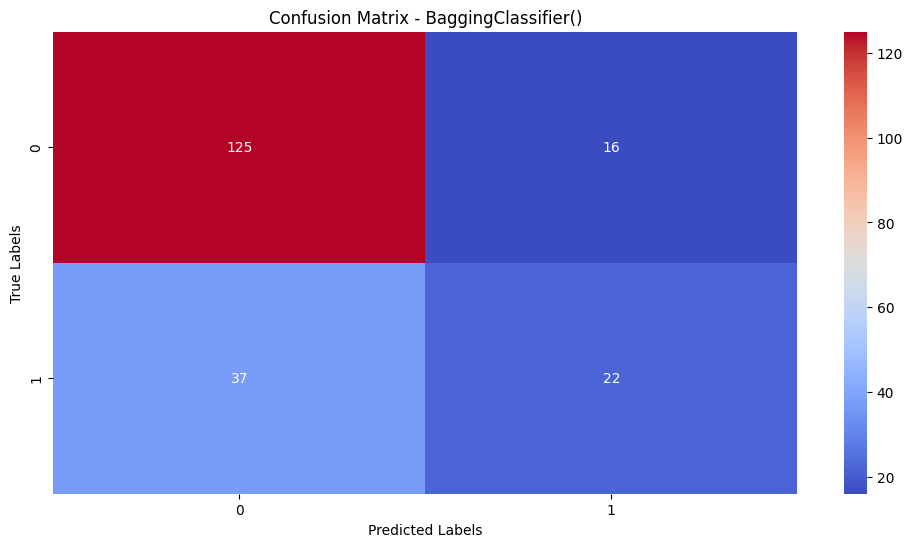

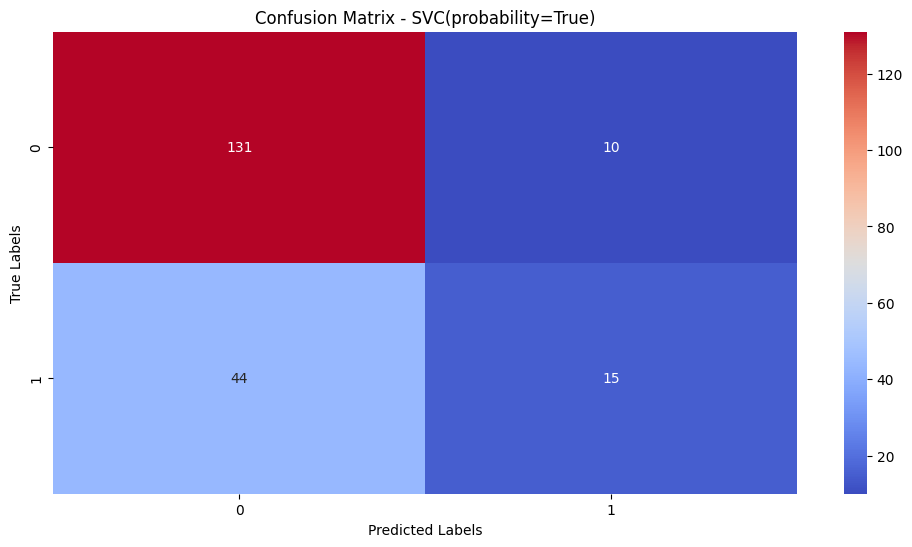

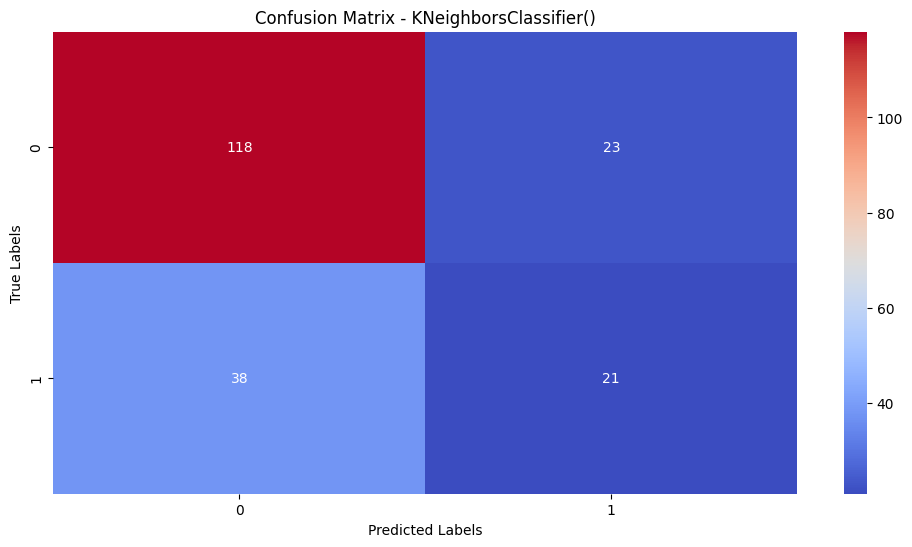

In [14]:
# confusion matrix to display TPR,TNR,FPR,FNR

def plot_confusion_matrix(y_test,y_pred,models):
    conmap = confusion_matrix(y_test,y_pred)
    plt.figure(figsize=(12,6))
    sns.heatmap(conmap,annot=True,fmt='d',cmap='coolwarm')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(f'Confusion Matrix - {models}')
    plt.show()




for model_name, model in models.items():

    model.fit(X_train_scaled,y_train)
    y_pred = model.predict(X_test_scaled)
    

    plot_confusion_matrix(y_test, y_pred, model)



In [15]:

logistic_regression_params = {
    'C': [0.001,0.01,0.1,1,10],
    'solver':['lbfgs','newton-cg','liblinear'],
    'max_iter':[1000,5000,1000],
    'penalty':['l1', 'l2', 'elasticnet', 'none']
}

gradient_boosting_params = {
    'learning_rate': [0.1, 0.01],
    'n_estimators': [100,200,300],
    'max_depth': [3,4,5]
}

random_forest_params = {
    'n_estimators': [50,100,200],
    'max_depth': [None,10,20],
    'min_samples_leaf':[1,2,4],
    'max_features': ['sqrt','log2',None],
    "criterion":["gini", "entropy"]
}

svc_params = {
    'C': [0.1,1,10,100,1000],
    'gamma': [1,0.1,0.01,0.001,0.0001],
    'kernel': ['rbf']
}

bagging_classifier_params = {
    'n_estimators': [50,100,200],
    'max_samples' : [1.0,0.8,0.6],
    'max_features': [1.0,0.8,0.6]
}


knn_params = {
    'n_neighbors' : [5,7,9,11,13,15],
    'weights' : ['uniform','distance'],
    'metric' : ['minkowski','euclidean','manhattan']
               }


models = {
    "LogisticRegression": (LogisticRegression(), logistic_regression_params),
    "RandomForestClassifier": (RandomForestClassifier(), random_forest_params),
    "GradientBoostingClassifier": (GradientBoostingClassifier(), gradient_boosting_params),
    "SVC": (SVC(probability=True), svc_params),
    "BaggingClassifier": (BaggingClassifier(), bagging_classifier_params),
    "kneighborsclassifier":(KNeighborsClassifier(),knn_params)
}

best_score = []


for model_name,(model,params) in models.items():
    model.fit(X_train_scaled,y_train)
    grid_search = GridSearchCV(model,params,cv=5,scoring="roc_auc",n_jobs=-1)
    grid_search.fit(X_train_scaled,y_train)
    print(f'Best Params for {model_name} : {grid_search.best_params_}')
    print(f'Best Score for {model_name} : {grid_search.best_score_ * 100:.2f}%')
    scores = {"Model":model_name,"RocAuc Score":grid_search.best_score_}
    best_score.append(scores)


best_score_df = pd.DataFrame(best_score)
print(best_score_df.head())

/home/nickkats1/sklearn_only/creditrisk/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:516: FitFailedWarning: 
600 fits failed out of a total of 900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "/home/nickkats1/sklearn_only/creditrisk/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/nickkats1/sklearn_only/creditrisk/venv/lib/python3.12/site-packages/sklearn/base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/nickkats1/

Best Params for LogisticRegression : {'C': 0.01, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'newton-cg'}
Best Score for LogisticRegression : 72.99%
Best Params for RandomForestClassifier : {'criterion': 'entropy', 'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 4, 'n_estimators': 100}
Best Score for RandomForestClassifier : 80.04%
Best Params for GradientBoostingClassifier : {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
Best Score for GradientBoostingClassifier : 77.41%
Best Params for SVC : {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}
Best Score for SVC : 74.73%
Best Params for BaggingClassifier : {'max_features': 0.6, 'max_samples': 1.0, 'n_estimators': 100}
Best Score for BaggingClassifier : 79.52%
Best Params for kneighborsclassifier : {'metric': 'manhattan', 'n_neighbors': 15, 'weights': 'distance'}
Best Score for kneighborsclassifier : 76.39%
                        Model  RocAuc Score
0          LogisticRegression      0.729894
1      RandomForestClassi